# Нейронная сеть для классификации сцен


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные
(можно загрузить и с kaggle)
просто zip папка с папками по классам, которые содержат изображения jpeg

In [ ]:
!wget https://www.dropbox.com/s/pnq8ej5c9ti1se7/intel_scene.zip?dl=1 -O intel_scene.zip

--2021-06-14 09:24:52--  https://www.dropbox.com/s/pnq8ej5c9ti1se7/intel_scene.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pnq8ej5c9ti1se7/intel_scene.zip [following]
--2021-06-14 09:24:53--  https://www.dropbox.com/s/dl/pnq8ej5c9ti1se7/intel_scene.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9cfc47e21e06492ae9bb243765.dl.dropboxusercontent.com/cd/0/get/BQammcCVXRX9ZheOZHMwER1sWqzSQ9dmGuggXqjwDes76wnKssZooHEc8AqoLuB2Cv-6hRScaapvts-K3RBMvlwN_4F_o9P-Msy0ZShha7LiP-u6knpHqR62xtOpvPDfBL6mZ_q58QlYXqbMwwUFPZf6/file?dl=1# [following]
--2021-06-14 09:24:53--  https://uc9cfc47e21e06492ae9bb243765.dl.dropboxusercontent.com/cd/0/get/BQammcCVXRX9ZheOZHMwER1sWqzSQ9dmGuggXqjwDes76wnKssZooHEc8AqoLuB2Cv-6hRScaapvts

распаковываем архив unzip

In [ ]:
#@title
!unzip intel_scene.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train

Посмотрим, какие еще каталоги с фотографиями есть в архиве (по количеству классов в наборе)

In [ ]:
!ls seg_train/seg_train

buildings  forest  glacier  mountain  sea  street


**Набор данных для обучения**

image_dataset_from_directory. Она читает изображение, которое находится в каталоге и создаёт из них набор данных для обучения, автоматически проставляя метки классов. Метки классов ставятся в зависимости от того, в каком каталоге находится то или иное изображение. Это как раз наш случай. У нас 6 каталогов. В каждом каталоге находится изображение одного класса. 

Как работает утилита image_dataset_from_directory? Необходимо указать 
1) путь,в котором находится каталоги с изображениями разных классов
2) размер мини выборки, набор данных большой, он не поместится целиком в память, поэтому изображения будут считаться с диска мини выборками, за один раз с диска будет читаться 128 изображений
3) размер изображений. Здесь мы используем 128 на 128. Хотя мы используем предварительно обученную сеть VGG16, и она обучена на наборе данных ImageNet на распознавание изображений размером 224 на 224, но для переноса обучения использовать тот же самый размер изображений не обязательно. Поэтому мы можем
указать свой размер, здесь  128 на 128. 

In [ ]:
train_dataset = image_dataset_from_directory('seg_train/seg_train',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=128,
                                             image_size=(128, 128))

Found 14034 files belonging to 6 classes.
Using 12631 files for training.


В наборе данных Intel Scene Classification
есть только две части: набор данных для обучения и набор данных для тестирования. Поэтому нам нужно самим создать набор данных для проверки. Для этого мы снова воспользуемся возможностями Keras,при загрузке набора данных указываем параметр validation_split равняется 0,1. Это означает,
что набор данных для обучения будет разбит на две части: 90 процентов будет использоваться для обучения, 10 процентов для проверки. При загрузке набора данных мы указываем, какой поднабор будет создан. 

In [ ]:
validation_dataset = image_dataset_from_directory('seg_train/seg_train',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=128,
                                             image_size=(128, 128))

Found 14034 files belonging to 6 classes.
Using 1403 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Выведем имеющиеся изображения на экран.

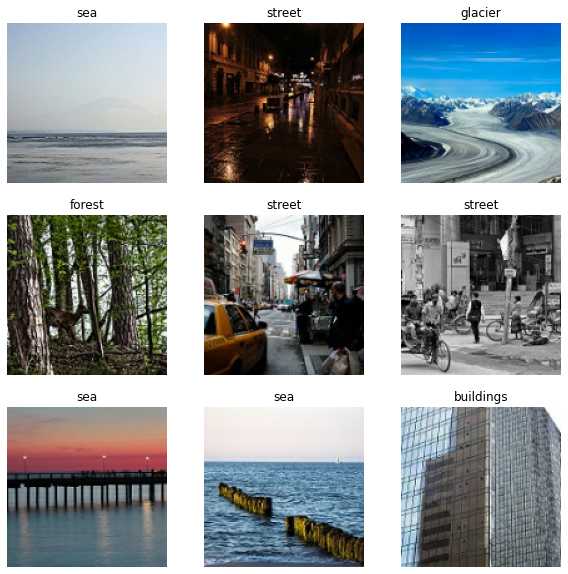

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [ ]:
test_dataset = image_dataset_from_directory('seg_test/seg_test',
                                             shuffle=True,
                                             label_mode='int',
                                             batch_size=128,
                                             image_size=(128, 128))

Found 3000 files belonging to 6 classes.


In [ ]:
test_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Для каждого набора данных мы устанавливаем, так называемый, prefetch. О чём это
говорит? Так как набор данных большой и целиком не помещается в память, то необходимо загружать
его с диска с порциями. Если не указывать другие настройки, то Keras будет загружать данные с диска
по одной мини выборке. При этом много времени будет тратиться на то, чтобы данные загрузились
с диска, и только после этого они будут передаваться в нейронную сеть для обучения. Для того чтобы
повысить производительность Keras на центральном процессоре занимается тем, что загружает данные с
диска, которые понадобятся через несколько шагов обучения, которые помещаются в буфер. Буфер Keras
определяет автоматически. 

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Создаем составную нейронную сеть

Мы создаем нейронную сеть с помощью конструктора VGG16. Указываем, что хотим загрузить предварительно обученные веса на наборе данных ImageNet, но при этом указываем параметры include_top=False. Это означает, что будет загружена только свёрточная часть сети VGG16, а полносвязная часть, которая отвечает за классификацию, и на выходе из которой 1000 нейронов, по тысяче классов объектов ImageNet загружена не будет. Эту часть мы заменим на свою собственную. 

Так как мы используем не тот формат изображений, на которые решить она сеть VGG16 по умолчанию, то мы указываем размер изображений 128 на 128. 3 говорит о том, что изображение цветные, три канала: red, green, blue. 

In [ ]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(128, 128, 3))

58892288/58889256 [==============================] - 0s 0us/step


Нам необходимо запретить изменять веса в нейронной сети VGG16 во время обучения, чтобы эти веса, обученные на наборе данных ImageNet, не испортились при дообучении на нашем наборе данных. Для этого в флаг trainable нейронной сети устанавливаем значения False. 

In [ ]:
vgg16_net.trainable = False

Теперь все готово к тому, чтобы создать составную сеть. 

Создаем ее с помощью модели класса Sequential. В качестве первого слоя добавляем слой Normalisation, этот слой обеспечивает, чтобы значения на входе в нейронную сеть были в диапазоне от нуля до единицы. 

Следующий шаг, который мы делаем, это добавляем в модель нашу предварительно
обученную сеть VGG16 в качестве отдельного слоя, Keras такое позволяет. 

После этого добавляем слой Flatten, который берет данные на выходе из свёрточной части VGG16, которые находятся в двумерном формате, и преобразует их в плоский формат. 

И вот эти три слоя – это наша классификационная часть, которую мы добавляем к свёрточной части предварительно обученной сети VGG16. Именно эти три слоя будут использоваться для классификации объектов из сцен набора данных Image на основе данных, которые выдаст свёрточная часть VGG16. Первый слой содержит 256 нейронов, затем слой Dropout с характеристикой 0,5, и на выходе полносвязный слой Dense, 6 нейронов, по количеству классов в наборе данных, и функция активации softmax.

In [ ]:
model = Sequential()
model.add(Normalization())
# Добавляем модель VGG16 в сеть как слой
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

**Компилируем модель**



Стоит обратить внимание, что тут используется sparse_categorical_crossentropy. Это та же самая categorical_crossentropy, но с другим форматом вывода ответов (не one hot encoding, а номера классов).

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Обучаем нейронную сеть

Так как мы используем наборы данных немножко в другом формате, которые нам создала утилита image_dataset_from_directory, здесь у нас нет отдельных
массивов для изображений и правильных ответов, а изображение и правильные ответы находятся вместе в наборе данных. 

В train_dataset находятся данные для обучения и правильные ответы, а в
validation_ dataset данные для проверки и правильные ответы для них. 

Также мы указываем количество эпох обучения 15. Размер мини выборки указывать не нужно, потому что мы указали его при создании наших datasets. Обучение одной эпохи  занимает  17 или 18 секунд.

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=15)

Epoch 1/15
99/99 [==============================] - 67s 301ms/step - loss: 2.2092 - accuracy: 0.7905 - val_loss: 0.3918 - val_accuracy: 0.8731
Epoch 2/15
99/99 [==============================] - 19s 185ms/step - loss: 0.4302 - accuracy: 0.8570 - val_loss: 0.3259 - val_accuracy: 0.8945
Epoch 3/15
99/99 [==============================] - 19s 191ms/step - loss: 0.3567 - accuracy: 0.8869 - val_loss: 0.3253 - val_accuracy: 0.9038
Epoch 4/15
99/99 [==============================] - 19s 192ms/step - loss: 0.2942 - accuracy: 0.9017 - val_loss: 0.3317 - val_accuracy: 0.9095
Epoch 5/15
99/99 [==============================] - 19s 187ms/step - loss: 0.2762 - accuracy: 0.9105 - val_loss: 0.3694 - val_accuracy: 0.9052
Epoch 6/15
99/99 [==============================] - 19s 186ms/step - loss: 0.2537 - accuracy: 0.9185 - val_loss: 0.3767 - val_accuracy: 0.9052
Epoch 7/15
99/99 [==============================] - 19s 188ms/step - loss: 0.2361 - accuracy: 0.9252 - val_loss: 0.3986 - val_accuracy: 0.9066

## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

24/24 [==============================] - 8s 337ms/step - loss: 0.5089 - accuracy: 0.8930


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 89.3


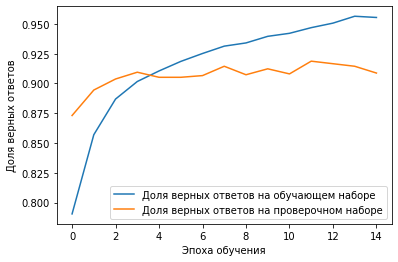

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

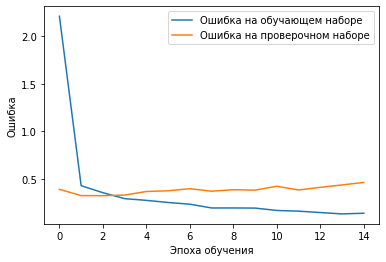

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Тонкая настройка нейронной сети

Мы размораживаем последний свёрточный блок, и после того как выполнили разморозку слоев, то есть сделали так, что они могут обучаться. Нам нужно заново скомпилировать нейронную сеть. Обратите внимание, что здесь мы указываем в оптимизатор adam, и у него меньше lr, единица на десять в минус пятой (малая скорость обучения).

разморозка последнего сверточного слоя

In [ ]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

малая скорость обучения

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


тонкая настройка требует небольшого количества эпох

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=4)

Epoch 1/4
99/99 [==============================] - 24s 216ms/step - loss: 0.1224 - accuracy: 0.9600 - val_loss: 0.4528 - val_accuracy: 0.9187
Epoch 2/4
99/99 [==============================] - 21s 208ms/step - loss: 0.0892 - accuracy: 0.9680 - val_loss: 0.4583 - val_accuracy: 0.9209
Epoch 3/4
99/99 [==============================] - 21s 212ms/step - loss: 0.0731 - accuracy: 0.9712 - val_loss: 0.4613 - val_accuracy: 0.9202
Epoch 4/4
99/99 [==============================] - 21s 210ms/step - loss: 0.0716 - accuracy: 0.9751 - val_loss: 0.4695 - val_accuracy: 0.9202


## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

24/24 [==============================] - 4s 161ms/step - loss: 0.5098 - accuracy: 0.9057


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 90.5667


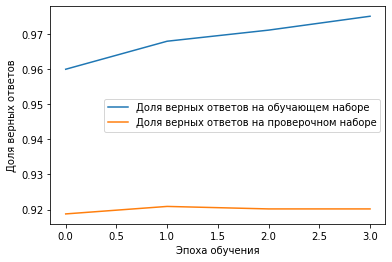

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("intel_image_model.h5")

In [ ]:
!ls

intel_image_model.h5  sample_data  seg_test
intel_scene.zip       seg_pred	   seg_train


Сохраняем модель на локальный компьютер

In [ ]:
files.download("intel_image_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Загружаем обученную нейронную сеть

In [ ]:
files.upload()

Saving intel_image_model.h5 to intel_image_model (1).h5


KeyboardInterrupt: ignored

In [ ]:
model = "intel_image_model.h5"

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

# Используем получившуюся нейронную сеть

Посмотрим данные получившейся нейронной сети


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 128, 128, 3)       7         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 16,813,645
Trainable params: 9,178,374
Non-trainable params: 7,635,271
_____________________________________

Загружаем картинку

In [ ]:
files.upload()

Saving горы_laplasian.jpg to горы_laplasian.jpg


{'горы_laplasian.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x04@\x06\xcc\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x00\x07\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\x00\t\xff\xc4\x00O\x10\x00\x02\x01\x03\x03\x03\x03\x02\x04\x05\x01\x06\x04\x02\x02\x13\x01\x02\x03\x04\x05\x11\x06\x12!\x00\x131\x07"A\x14Q#2aq\x08\x15B\x81\x91\xa1\x16$3R\xb1\xc1b\xd1\xe1\xf0

Просматриваем картинку

In [ ]:
filename = 'кот.jpg'
img = image.load_img(filename, target_size=(128, 128))
plt.imshow(img)
plt.show()

FileNotFoundError: ignored

Преобразуем картинку в массив

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


Запускаем распознавание

In [ ]:
prediction = model.predict(x)
prediction

Вспомним имеющиеся класссы. Можно уже посмотреть на степень, число с наименьшей степенью и будет самым вероятным классом.

In [ ]:

print("Название класса:", class_names)

Выведем результат в более удобном виде

In [ ]:
pred =[prediction[0][0], prediction[0][1], prediction[0][2], prediction[0][3], prediction[0][4], prediction[0][5]]
print(pred)

In [ ]:
for i in range(0, len(pred)):
    maximum = pred[0]
    maxi = 0
    for i in range(0, len(pred)):
        if pred[i] > maximum:
            maximum = pred[i]

    for i in range(0, len(pred)):
      if pred[i] == maximum:
        print(class_names[i])
        print(round(pred[i]*100, 4) , '%')
        pred[i] = -1
        break


Ответы даны в порядке от наиболее вероятных к менее вероятным.